# 📑 Summary 📑

## 📌 Task 📌

To combine pre-trained word embeddings (custom or BERT) with dependency parse trees to train edge conditioned convolution graph networks for sentiment classification.

1. Explore how dependency parsing works
2. Tokenize sentences and give them to the dependency parser
3. Obtain the relationships and check them
4. Convert the dependency graphs from the parser into the graphs that can be used for GCN
5. Explore GCN and try to build graphs from the parsed dependency graphs
6. Perform graph level classification
7. Check performance
8. Refine the various layers and hyperparameters in the process
9. Check final performance
10. Do interpreation manually on some selected examples
11. Implement edge masking to get the minimum subgraph
12. Performe automatic interpretation of the graphs to determine the most important terms/relationships for each sentence

## 📐 Method 📐

* For dependency parsing, we will try to use the tools from the stanford nlp group.
* The *[CoreNLP](https://github.com/stanfordnlp/CoreNLP)* library is important as it contains many of the tools needed to performe dependency parsing
* The *[stanza](https://github.com/stanfordnlp/stanza)* library offers a wrapped version of CoreNLP that works directly with Python
* Visualization of the graphs can be done using *[networkx](https://github.com/networkx/networkx)*
* For GCN and word-level graphs we will primarily look at the ideas in this *[tutorial](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial7/GNN_overview.html)*
* We will try to use the *[spektral](https://github.com/danielegrattarola/spektral/)* library to implement the graphs convolution and attention 
* *[Link](https://universaldependencies.org/u/dep/)* to explaination of dependency relations.
* *[Link](https://nlp.stanford.edu/software/nndep.html)* to explaination of dependency parsing

## 📀 Dataset 📀

The dataset is still IMDB review but we may expand later on

## 🧮 Results 🧮

Read the notebook

## 🎬 Conclusion 🎬

Read the manuscript

# 👾 Code 👾

## 𖢞 Part 1: Dependency Parsing 𖢞

### 📦 Basic Imports 📦

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stanza
import networkx as nx
import spacy
import stanzaTools
stanza.download('en')

### 🔎 Testing Stanza 🔎

In [57]:
sampleSentence = "There is nothing wrong with Apple's new M1 Max Chip, everything works so well! Ok this might be kind of difficult."

In [58]:
nlp = stanza.Pipeline(
    'en',
    processors = 'tokenize,mwt,pos,lemma,depparse, sentiment')

2022-06-07 15:34:06 WARNING: Can not find mwt: default from official model list. Ignoring it.
2022-06-07 15:34:07 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |
| sentiment | sstplus  |

INFO:stanza:Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |
| sentiment | sstplus  |

2022-06-07 15:34:07 INFO: Use device: cpu
INFO:stanza:Use device: cpu
2022-06-07 15:34:07 INFO: Loading: tokenize
INFO:stanza:Loading: tokenize
2022-06-07 15:34:07 INFO: Loading: pos
INFO:stanza:Loading: pos
2022-06-07 15:34:07 INFO: Loading: lemma
INFO:stanza:Loading: lemma
2022-06-07 15:34:07 INFO: Loading: depparse
INFO:stanza:Loading: depparse
2022-06-07 15:34:07 INFO: Loading: sentiment
INFO:stanza:Loading: se

In [59]:
doc = nlp(sampleSentence)

In [69]:
doc.sentences[0].words[0:3]

[{
   "id": 1,
   "text": "There",
   "lemma": "there",
   "upos": "PRON",
   "xpos": "EX",
   "head": 2,
   "deprel": "expl",
   "start_char": 0,
   "end_char": 5
 },
 {
   "id": 2,
   "text": "is",
   "lemma": "be",
   "upos": "VERB",
   "xpos": "VBZ",
   "feats": "Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin",
   "head": 0,
   "deprel": "root",
   "start_char": 6,
   "end_char": 8
 },
 {
   "id": 3,
   "text": "nothing",
   "lemma": "nothing",
   "upos": "PRON",
   "xpos": "NN",
   "feats": "Number=Sing",
   "head": 2,
   "deprel": "nsubj",
   "start_char": 9,
   "end_char": 16
 }]

In [70]:
sent_dict = doc.sentences[0].to_dict()

#### 📊 tokenRelationHead 📊

In [71]:
stanzaTools.tokenRelationHead(sent_dict)

Token           | Relation   | Head            
--------------------------------------------------
There           | expl       | is              
is              | root       | ROOT            
nothing         | nsubj      | is              
wrong           | amod       | nothing         
with            | case       | Max             
Apple           | nmod:poss  | Max             
's              | case       | Apple           
new             | amod       | Max             
M1              | compound   | Max             
Max             | nmod       | nothing         
Chip            | flat       | Max             
,               | punct      | works           
everything      | nsubj      | works           
works           | parataxis  | is              
so              | advmod     | well            
well            | advmod     | works           
!               | punct      | is              


#### 🐝 getNodeEdgeLists 🐝 

In [73]:
nodeList, edgeList = stanzaTools.getNodeEdgeLists(doc)

In [75]:
nodeList[0:3]

[{'id': 1,
  'text': 'There',
  'lemma': 'there',
  'upos': 'PRON',
  'xpos': 'EX',
  'head': 2,
  'deprel': 'expl',
  'start_char': 0,
  'end_char': 5},
 {'id': 2,
  'text': 'is',
  'lemma': 'be',
  'upos': 'VERB',
  'xpos': 'VBZ',
  'feats': 'Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin',
  'head': 0,
  'deprel': 'root',
  'start_char': 6,
  'end_char': 8},
 {'id': 3,
  'text': 'nothing',
  'lemma': 'nothing',
  'upos': 'PRON',
  'xpos': 'NN',
  'feats': 'Number=Sing',
  'head': 2,
  'deprel': 'nsubj',
  'start_char': 9,
  'end_char': 16}]

#### 📊 drawDepGraph 📊

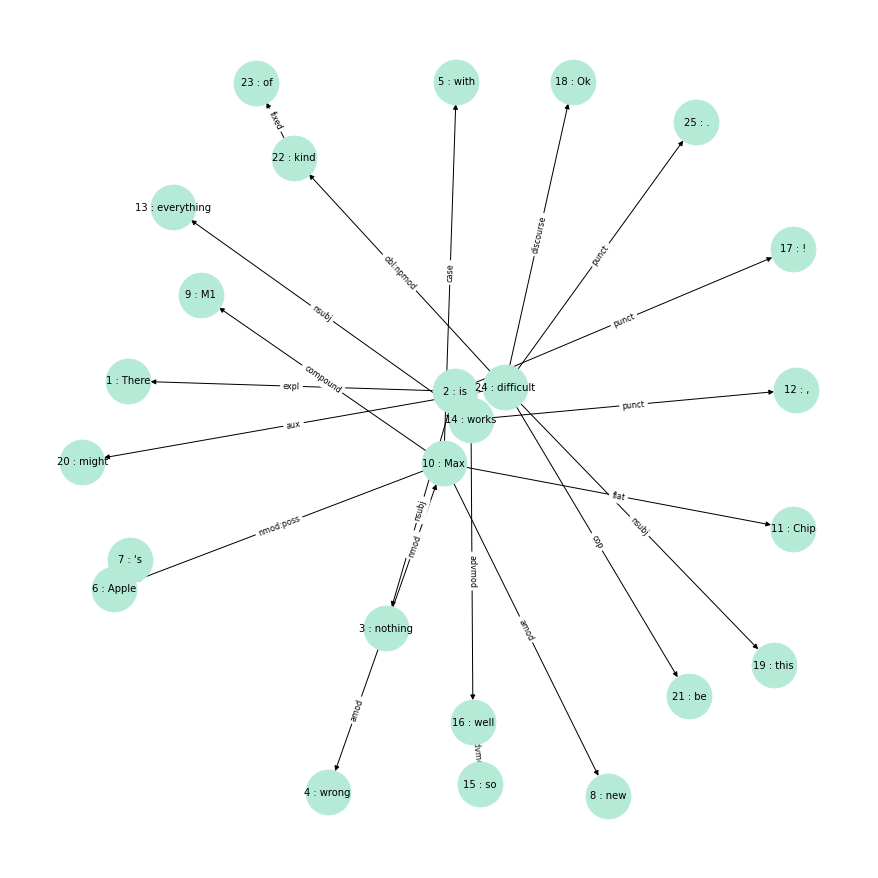

In [76]:
stanzaTools.drawDepGraph(nodeList, edgeList)

### 🔎 Testing Spacy (SKIP for Now) 🔎

In [ ]:
import spacy

# Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")

# Process whole documents
text = sampleSentence
doc = nlp(text)
# Analyze syntax
print("Noun phrases:", [chunk.text for chunk in doc.noun_chunks])
print("Verbs:", [token.lemma_ for token in doc if token.pos_ == "VERB"])

# Find named entities, phrases and concepts
for entity in doc.ents:
    print(entity.text, entity.label_)    

In [ ]:
spacy.displacy.render(doc, style='dep', jupyter=True, options={'distance': 120})

In [ ]:
doc

### 🔎 Testing TF Datasets 🔎

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import spacy
import tfDatasetTools
nlp = spacy.load("en_core_web_sm")

In [ ]:
trainDS = tfds.load('imdb_reviews', split='train', as_supervised=True, shuffle_files=True)
testDS = tfds.load('imdb_reviews', split='test', as_supervised=True, shuffle_files=True)

In [ ]:
part = testDS.take(10)

#### 🐝 decodeZeroDimTensor 🐝

moved to tfDatasetTools.py

#### 🐝 convertTakeDataset 🐝

In [ ]:
features, labels = tfDatasetTools.convertTakeDataset(part)

In [ ]:
features[0]

In [ ]:
labels

In [ ]:
nlp = stanza.Pipeline(
    'en',
    processors = 'tokenize,mwt,pos,lemma,depparse, sentiment')

In [ ]:
doc = nlp(features[1])
for sentence in doc.sentences:
    print(sentence.text)
    print(sentence.sentiment)

In [ ]:
doc.sentences[1]

### 🔎 Testing spektral 🔎

In [ ]:
import spektral
from spektral.datasets import TUDataset

In [ ]:
dataset = TUDataset('PROTEINS')

In [ ]:
dataset

In [ ]:
train_datset = dataset[:100]

In [ ]:
test_datset = dataset[100:]

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from spektral.layers import GCNConv, GlobalSumPool

In [ ]:
class MyFirstGNN(Model):

    def __init__(self, n_hidden, n_labels):
        super().__init__()
        self.graph_conv = GCNConv(n_hidden)
        self.pool = GlobalSumPool()
        self.dropout = Dropout(0.5)
        self.dense = Dense(n_labels, 'softmax')

    def call(self, inputs):
        out = self.graph_conv(inputs)
        out = self.dropout(out)
        out = self.pool(out)
        out = self.dense(out)

        return out

In [ ]:
model = MyFirstGNN(32, dataset.n_labels)
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from spektral.data import BatchLoader

loader = BatchLoader(train_datset, batch_size=32)
testLoader = BatchLoader(test_datset, batch_size=32)

In [ ]:
model.fit(loader.load(),steps_per_epoch=loader.steps_per_epoch, epochs=10)

In [ ]:
model.evaluate(testLoader.load(),steps=testLoader.steps_per_epoch)

In [ ]:
test_datset[12].y

## ፨ Part 2: Graph Networks ፨ 

### 📦 Basic Imports 📦 

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stanza
import networkx as nx
import tensorflow_hub as hub
import tensorflow_text
import spektral

In [2]:
import stanzaTools
import tfDatasetTools
import relationEncoder

In [3]:
import io, time, joblib, json
from importlib import reload

### 📦 Set up Stanza 📦

In [7]:
stanza.download('en')

2022-06-05 16:03:23 INFO: Downloading default packages for language: en (English)...
2022-06-05 16:03:24 INFO: File exists: /Users/zeyuyang/stanza_resources/en/default.zip
2022-06-05 16:03:27 INFO: Finished downloading models and saved to /Users/zeyuyang/stanza_resources.


### 📀 Load Data 📀

In [10]:
trainDS = tfds.load('imdb_reviews', split='train', as_supervised=True, shuffle_files=True)
testDS = tfds.load('imdb_reviews', split='test', as_supervised=True, shuffle_files=True)

Metal device set to: Apple M1 Max


2022-06-07 14:21:06.976083: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-07 14:21:06.976329: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### 🫥 Set a Limit 🫥

In [11]:
trainLimit = 25000
testLimit = 25000

trainSubset = trainDS.take(trainLimit)
testSubset = testDS.take(testLimit)

In [12]:
validationSplit = 0.2
validationIndex = int(validationSplit * trainLimit)

validationSplitSubset = trainSubset.take(validationIndex)
trainSplitSubset = trainSubset.skip(validationIndex)

In [13]:
trainFeatures, trainLabels = tfDatasetTools.convertTakeDataset(trainSplitSubset)
valFeatures, valLabels = tfDatasetTools.convertTakeDataset(validationSplitSubset)
testFeatures, testLabels = tfDatasetTools.convertTakeDataset(testSubset)

2022-06-07 14:21:11.534515: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


##### 📦 Load the right stanza Pipeline 📦

In [100]:
nlp = stanza.Pipeline(
    'en',
    processors = 'tokenize, mwt')

2022-06-07 17:26:06 WARNING: Can not find mwt: default from official model list. Ignoring it.
2022-06-07 17:26:06 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |

INFO:stanza:Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |

2022-06-07 17:26:06 INFO: Use device: cpu
INFO:stanza:Use device: cpu
2022-06-07 17:26:06 INFO: Loading: tokenize
INFO:stanza:Loading: tokenize
2022-06-07 17:26:06 INFO: Done loading processors!
INFO:stanza:Done loading processors!


#### 🤖Create Custom tokenizer🤖
The goal is to matche our tokenizer to the one used by stanza. The ideas is to first tokenize all of the train+validation reviews into words. Then use our own tokenizer to parse all of these words to learn what the vocabulary is. Later, we will use stanza to break each feature into a list of nodes. The list of nodes will be converted using our own tokenizer into a list of ints. The list of ints will be used to train the embedding model and to create the embeddings for the graph model.

Use joblib with parallel jobs to speed up the processing by about 200%.

In [15]:
def getStanzaProSents(features):
    tokenizedSentences = []
    for feature in features:
        doc = nlp(feature)
        for sentence in doc.sentences:
            tokenizedSentences.append(" ".join([item['text'] for item in sentence.to_dict()]))
    return tokenizedSentences

This takes about 42 seconds per 1000 reviews

In [16]:
startTime = time.perf_counter()
step = 50
totalFeatures = trainFeatures + valFeatures
results = joblib.Parallel(n_jobs=8, prefer="threads")(joblib.delayed(getStanzaProSents)(totalFeatures[i:i + step]) for i in range(0,trainLimit,step))
print(time.perf_counter()-startTime)
deListed = []
for i in results:
    deListed += i

1129.3985874999998


In [17]:
customTokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=30000, oov_token='OOVTOKEN', filters='', lower = True, split = ' ')

In [18]:
customTokenizer.fit_on_texts(deListed)

In [19]:
file_path = './tokenizer/token' + '25000' + '.json'

In [20]:
# use if you want to rewrite the file
tokenizer_json = customTokenizer.to_json()
with io.open(file_path, 'w', encoding='utf-8') as f:
            f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [7]:
with open(file_path) as f:
            data = json.load(f)
            customTokenizer = tf.keras.preprocessing.text.tokenizer_from_json(data)

In [21]:
len(customTokenizer.index_word)

82222

In [22]:
one = customTokenizer.texts_to_sequences([trainFeatures[0]])

In [23]:
customTokenizer.sequences_to_texts(one)

["it is amazing to me what passes for entertainment OOVTOKEN maybe i am a dinosaur from the OOVTOKEN and i am out of touch with todays movie going OOVTOKEN and apparently that is the case with regards to this OOVTOKEN since so many people loved OOVTOKEN i found it foul and OOVTOKEN i OOVTOKEN said that about many movies in my life but this one fits the OOVTOKEN the humor is sophomoric and OOVTOKEN i am not a politically correct OOVTOKEN and even i found the gay OOVTOKEN not only not funny but downright offensive ( i'm not OOVTOKEN the main character in the movie is not even a likable OOVTOKEN just OOVTOKEN when the movie was finally over i heard a number of people comment on how disappointed they were in what they had just pay good money to OOVTOKEN"]

#### 💽Bert Embeddings (not used too expensive)💽

In [24]:
tf.keras.backend.clear_session()

In [411]:
# Preprocess and encode input
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)

preprocessor = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
encoder_inputs = preprocessor(text_input)

encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2',trainable=False)

outputs = encoder(encoder_inputs)

pooled_output = outputs['pooled_output'] # [batch_size, 128].
# [batch_size, seq_length, 128].

sequence_output = outputs['sequence_output']

2022-05-29 23:02:06.956843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


##### 🐛 Sample Convert to BERT Embedding 🐛

In [412]:
text = "hello there who are you hello there who are you hello there who are you hello there who are you hello there who are you hello there who are you"
words = text.split()
converted = stanzaTools.convertToEmbedding(words, preprocessor, encoder)

2022-05-29 23:02:11.958773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-29 23:02:12.132296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [413]:
converted.shape

(30, 128)

In [414]:
converted = stanzaTools.convertToEmbedding(['!'], preprocessor, encoder)

In [415]:
word = ['hello', 'there']
convertedWords = stanzaTools.convertToEmbedding(word, preprocessor, encoder)

In [416]:
convertedWords.shape

(2, 128)

#### 💽Training Custom Embeddings💽

Tokenize and pad the train and val features

In [77]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [26]:
MAX_SEQUENCE_LENGTH = 256

In [27]:
xTrain = customTokenizer.texts_to_sequences(trainFeatures)
xTrain = pad_sequences(xTrain, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

In [28]:
yTrain = np.array(trainLabels)
print(xTrain.shape)
print(yTrain.shape)

(20000, 256)
(20000,)


In [29]:
xValidation = customTokenizer.texts_to_sequences(valFeatures)
xValidation = pad_sequences(xValidation, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

In [30]:
yValidation = np.array(valLabels)
print(xValidation.shape)
print(yValidation.shape)

(5000, 256)
(5000,)


In [31]:
testLimit = 25000

In [32]:
xTest = customTokenizer.texts_to_sequences(testFeatures[0:testLimit])
xTest = pad_sequences(xTest, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

In [33]:
yTest = np.array(testLabels[0:testLimit])
print(xTest.shape)
print(yTest.shape)

(25000, 256)
(25000,)


In [36]:
tf.random.set_seed(420)
np.random.seed(420)

Make the model

In [37]:
def sampleModel():
    sequence_input = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedding_layer = tf.keras.layers.Embedding(30000,
                                                16)(sequence_input)
    pool = tf.keras.layers.GlobalAveragePooling1D()(embedding_layer)
    dense_layer = tf.keras.layers.Dense(16, activation='relu')(pool)
    dropout_layer = tf.keras.layers.Dropout(0.3)(dense_layer)
    outputs = tf.keras.layers.Dense(1)(dropout_layer)

    return tf.keras.Model(inputs=sequence_input, outputs=outputs)

In [38]:
tf.keras.backend.clear_session()
embeddingModel = sampleModel()
embeddingModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256)]             0         
                                                                 
 embedding (Embedding)       (None, 256, 16)           480000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                             

In [39]:
embeddingModel.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [40]:
history = embeddingModel.fit(
    xTrain,
    yTrain,
    validation_data=(xValidation, yValidation),
    epochs=5,
    verbose=1)

Epoch 1/5


2022-06-07 15:25:50.698912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


622/625 [============================>.] - ETA: 0s - loss: 0.6018 - accuracy: 0.5964

2022-06-07 15:25:58.387285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 8s 13ms/step - loss: 0.6010 - accuracy: 0.5974 - val_loss: 0.4440 - val_accuracy: 0.7610
Epoch 2/5
625/625 [==============================] - 8s 13ms/step - loss: 0.3553 - accuracy: 0.8384 - val_loss: 0.3397 - val_accuracy: 0.8610
Epoch 3/5
625/625 [==============================] - 7s 12ms/step - loss: 0.2653 - accuracy: 0.8846 - val_loss: 0.3180 - val_accuracy: 0.8600
Epoch 4/5
625/625 [==============================] - 9s 14ms/step - loss: 0.2123 - accuracy: 0.9099 - val_loss: 0.3200 - val_accuracy: 0.8734
Epoch 5/5
625/625 [==============================] - 9s 14ms/step - loss: 0.1653 - accuracy: 0.9313 - val_loss: 0.3216 - val_accuracy: 0.8722


In [44]:
results = embeddingModel.evaluate(x=xTest, y=yTest)

782/782 [==============================] - 3s 4ms/step - loss: 0.3558 - accuracy: 0.8477


In [41]:
savePath = "./embeddingModel/embed16_25k"
embeddingModel.save(savePath)

INFO:tensorflow:Assets written to: ./embeddingModel/embed16_25k/assets


INFO:tensorflow:Assets written to: ./embeddingModel/embed16_25k/assets


**If you want to load a pre-existing model**

In [45]:
loadedModel = tf.keras.models.load_model(savePath)
loadedModel.layers

##### 🐛Sample Convert to Custom Embeddings (for debug purposes)🐛

In [49]:
embeddingModel.layers[1]

In [52]:
listOfWords = "why did I do this".split()
listOfWords

['why', 'did', 'I', 'do', 'this']

In [53]:
sequence = customTokenizer.texts_to_sequences(listOfWords)
sequence

[[147], [83], [12], [50], [13]]

In [54]:
reshapedSeq = np.array([item[0] for item in sequence])
reshapedSeq

array([147,  83,  12,  50,  13])

In [55]:
embeddedSeq = embeddingModel.layers[1](reshapedSeq)
np.array(embeddedSeq)

array([[-0.06583753, -0.14925908, -0.07439847, -0.11051435,  0.13862614,
         0.09201127, -0.16731969, -0.1010332 , -0.13546863,  0.13432755,
         0.08380182, -0.04522675,  0.08616781,  0.08880984,  0.03236263,
        -0.07402526],
       [-0.03517925, -0.09838024, -0.09140101, -0.08225321,  0.09395648,
         0.12466376, -0.0624707 , -0.1158405 , -0.07749478,  0.12928651,
         0.03179754, -0.09451605,  0.12110313,  0.1594039 ,  0.0286512 ,
        -0.06960334],
       [ 0.03472452,  0.02322617, -0.03128216,  0.04207388, -0.04271244,
         0.01156361,  0.05967582, -0.0290033 , -0.03640172, -0.02010541,
        -0.02718968, -0.05278517, -0.01194761,  0.05206764, -0.153005  ,
         0.06796191],
       [-0.04292245, -0.16216798, -0.10949111, -0.13775189,  0.10121065,
         0.06401047, -0.08168249, -0.14128214, -0.08900571,  0.05968   ,
         0.0589614 , -0.07539045,  0.07043786,  0.11637982,  0.02042517,
        -0.10202847],
       [-0.02709097, -0.03695998, -0

#### 🐝 convertToCustomEmbedding 🐝

In [78]:
def convertToCustomEmbedding(words):
    """
    Takes a list of words and converts it to a list of custom embeddings. 

    Args:
        words - (list) The list of words to convert
    Returns:
        embeddings - (list) A list of embeddings
    """
    sequence = customTokenizer.texts_to_sequences(words)
    reshapedSeq = np.array([item[0] for item in sequence])
    try:
        convertedWords = embeddingModel.layers[1](reshapedSeq)
    except:
        print(words)
        print(reshapedSeq)
    return np.array(convertedWords)

#### 🐝 createGraph 🐝

In [46]:
reload(stanzaTools)
reload(tfDatasetTools)

<module 'tfDatasetTools' from '/Users/zeyuyang/Projects/CS397Project/tfDatasetTools.py'>

In [47]:
relationsDict = relationEncoder.getRelationsDict()

❗️**ONLY USE createGraphAlpha THE REST ARE TOO SLOW AND MAY THROW ERRORS**❗️

In [ ]:
def createGraph(doc, positive):
    startTime = time.perf_counter()
    nodeList, edgeList = stanzaTools.getNodeEdgeLists(doc)
    nodeTime = time.perf_counter()
    words = [item['text'] for item in nodeList]
    convertedFeatures = stanzaTools.convertToEmbedding(words, preprocessor, encoder)
    adjacencyMatrix = stanzaTools.createAdjacencyMatrix(edgeList, len(nodeList))
    convertTime = time.perf_counter()
    sortedList = sorted(edgeList, key=lambda x: (x['edgePair'][0], x['edgePair'][1]))
    edgeFeatures = relationEncoder.OneHotEncode(relationsDict, [edge['edgeLabel'] for edge in sortedList])
    encodeTime = time.perf_counter()
    label = np.array([positive])
    print([nodeTime - startTime, convertTime  - nodeTime, encodeTime - convertTime])
    # newGraph = spektral.data.graph.Graph(x=convertedFeatures, a=adjacencyMatrix, y=label)
    return (convertedFeatures, adjacencyMatrix, edgeFeatures, label)

In [ ]:
def createCustomGraph(doc, positive):
    startTime = time.perf_counter()
    nodeList, edgeList = stanzaTools.getNodeEdgeLists(doc)
    nodeTime = time.perf_counter()
    words = [item['text'] for item in nodeList]
    convertedFeatures = stanzaTools.convertToCustomEmbedding(words, preprocessor, model.layers[2])
    adjacencyMatrix = stanzaTools.createAdjacencyMatrix(edgeList, len(nodeList))
    convertTime = time.perf_counter()
    sortedList = sorted(edgeList, key=lambda x: (x['edgePair'][0], x['edgePair'][1]))
    edgeFeatures = relationEncoder.OneHotEncode(relationsDict, [edge['edgeLabel'] for edge in sortedList])
    encodeTime = time.perf_counter()
    label = np.array([positive])
    print([nodeTime - startTime, convertTime  - nodeTime, encodeTime - convertTime])
    # newGraph = spektral.data.graph.Graph(x=convertedFeatures, a=adjacencyMatrix, y=label)
    return (convertedFeatures, adjacencyMatrix, edgeFeatures, label)

In [ ]:
def createCustomGraph2(doc, positive):
    startTime = time.perf_counter()
    nodeList, edgeList = stanzaTools.getNodeEdgeLists(doc)
    nodeTime = time.perf_counter()
    words = [item['text'] for item in nodeList]
    print(len(words))
    convertedFeatures = convertToCustomEmbedding(words)
    adjacencyMatrix = stanzaTools.createAdjacencyMatrix(edgeList, len(nodeList))
    convertTime = time.perf_counter()
    sortedList = sorted(edgeList, key=lambda x: (x['edgePair'][0], x['edgePair'][1]))
    edgeFeatures = relationEncoder.OneHotEncode(relationsDict, [edge['edgeLabel'] for edge in sortedList])
    encodeTime = time.perf_counter()
    label = np.array([positive])
    print([nodeTime - startTime, convertTime  - nodeTime, encodeTime - convertTime])
    # newGraph = spektral.data.graph.Graph(x=convertedFeatures, a=adjacencyMatrix, y=label)
    return (convertedFeatures, adjacencyMatrix, edgeFeatures, label)

#### 🐝 **createGraphAlpha** 🐝

In [48]:
def createGraphAlpha(doc, positive):
    # startTime = time.perf_counter()
    nodeList, edgeList = stanzaTools.getNodeEdgeLists(doc, False, False)
    # nodeTime = time.perf_counter()
    words = [item['text'] for item in nodeList]
    # print(len(words))
    convertedFeatures = convertToCustomEmbedding(words)
    adjacencyMat𑗊rix = stanzaTools.createAdjacencyMatrix(edgeList, len(nodeList))
    # convertTime = time.perf_counter()
    sortedList = sorted(edgeList, key=lambda x: (x['edgePair'][0], x['edgePair'][1]))
    edgeFeatures = relationEncoder.OneHotEncode(relationsDict, [edge['edgeLabel'] for edge in sortedList])
    # encodeTime = time.perf_counter()
    label = np.array([positive])
    # print([nodeTime - startTime, convertTime  - nodeTime, encodeTime - convertTime])
    # newGraph = spektral.data.graph.Graph(x=convertedFeatures, a=adjacencyMatrix, y=label)
    return (convertedFeatures, adjacencyMatrix, edgeFeatures, label)

### 🤖 Convert Data to Graph Format 🤖

Now we need the full pipeline

In [112]:
nlp = stanza.Pipeline(
    'en',
    processors = 'tokenize,mwt,pos,lemma,depparse, sentiment')

2022-06-07 17:45:34 WARNING: Can not find mwt: default from official model list. Ignoring it.
2022-06-07 17:45:35 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |
| sentiment | sstplus  |

INFO:stanza:Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |
| sentiment | sstplus  |

2022-06-07 17:45:35 INFO: Use device: cpu
INFO:stanza:Use device: cpu
2022-06-07 17:45:35 INFO: Loading: tokenize
INFO:stanza:Loading: tokenize
2022-06-07 17:45:35 INFO: Loading: pos
INFO:stanza:Loading: pos
2022-06-07 17:45:35 INFO: Loading: lemma
INFO:stanza:Loading: lemma
2022-06-07 17:45:35 INFO: Loading: depparse
INFO:stanza:Loading: depparse
2022-06-07 17:45:35 INFO: Loading: sentiment
INFO:stanza:Loading: se

#### 🐝 convertToGraph🐝

In [80]:
def convertToGraph(sentence, label):
    doc = nlp(sentence)
    newGraph = createGraphAlpha(doc, label)
    del(doc)
    return newGraph

##### 🤗**Train Graphs**🤗

In [81]:
numTrain = len(trainFeatures)
numVal = len(valFeatures)
numTest = 25000

In [82]:
startTime = time.perf_counter()
# trainGraphs = [convertToGraph(trainFeatures[i], trainLabels[i]) for i in range(10)]
trainGraphs = joblib.Parallel(n_jobs=8, prefer="threads")(joblib.delayed(convertToGraph)(trainFeatures[i], trainLabels[i]) for i in range(numTrain))
timeElapsed = time.perf_counter() - startTime
print(timeElapsed)

2486.1492048749988


In [102]:
print(len(trainGraphs))

20000


In [105]:
[item.shape for item in trainGraphs[0]]

[(158, 16), (158, 158), (150, 51), (1,)]

meaning of output:

[(nodes), (adjacency), (edges), (label)]

meaning of dims:

[(# of nodes, # of nodes dims),( # of nodes,  # of nodes),(# of edges, # of edge types),(# of labels,)]

##### 🥵**Validation Graphs**🥵

In [96]:
numVal

5000

In [97]:
startTime = time.perf_counter()
validationGraphs = joblib.Parallel(n_jobs=8, prefer="threads")(joblib.delayed(convertToGraph)(valFeatures[i], valLabels[i]) for i in range(numVal))
timeElapsed = time.perf_counter() - startTime
print(timeElapsed)

643.4632887499993


In [101]:
print(len(validationGraphs))

5000


In [110]:
[item.shape for item in validationGraphs[0]]

[(134, 16), (134, 134), (125, 51), (1,)]

##### 😳 **Test Graphs** 😳

In [113]:
startTime = time.perf_counter()
testGraphs = joblib.Parallel(n_jobs=8, prefer="threads")(joblib.delayed(convertToGraph)(testFeatures[i], testLabels[i]) for i in range(numTest))
timeElapsed = time.perf_counter() - startTime
print(timeElapsed)

3177.3946277080013


In [114]:
print(len(testGraphs))

25000


In [115]:
[item.shape for item in testGraphs[0]]

[(220, 16), (220, 220), (210, 51), (1,)]

#### 🏎 Speed test (I AM SPEED) 🏎

In [802]:
sentences = []
labels = []
for i in range(10):
    sentence = trainFeatures[i]
    label = trainLabels[i]
    sentences.append(sentence)
    labels.append(label)

In [871]:
for sentence in sentences[0:5]:
    print(sentence[0:100])

I love this show!  Every time i watch an episode i repeat that line and remind myself how good of a 
I gave it a 10, since everyone else seemed to like it and it would have been churlish not to. The re
Considering its pedigree, this should be a far more enjoyable film than it is. Even with a lip-smack
Give this movie a break! Its worth at least a "7"! That little girl is a good actor and she's cute, 
Actually had to stop it. Don't get me wrong, love bad monster movies. But this one was way too borin


In [803]:
import time

In [804]:
startTime = time.perf_counter()
docs = []
for sentence in sentences:
    doc = nlp(sentence)
    docs.append(doc)
timeElapsed = time.perf_counter() - startTime
print(timeElapsed)

3.5648865830007708


In [872]:
for doc in docs[0:5]:
    print(doc.sentences[0].text)

I love this show!
I gave it a 10, since everyone else seemed to like it and it would have been churlish not to.
Considering its pedigree, this should be a far more enjoyable film than it is.
Give this movie a break!
Actually had to stop it.


In [873]:
def runDepenParse(sentence):
    return(nlp(sentence))

In [880]:
startTime = time.perf_counter()
parallelDocs = joblib.Parallel(n_jobs=8, prefer="threads")(joblib.delayed(nlp)(sentences[i]) for i in range(len(sentences)))
timeElapsed = time.perf_counter() - startTime
print(timeElapsed)

1.400063583991141


In [881]:
for doc in parallelDocs[0:5]:
    print(doc.sentences[0].text)

I love this show!
I gave it a 10, since everyone else seemed to like it and it would have been churlish not to.
Considering its pedigree, this should be a far more enjoyable film than it is.
Give this movie a break!
Actually had to stop it.


In [815]:
performanceTest = []
startTime = time.perf_counter()
for i in range(len(docs)):
    doc = docs[i]
    label = labels[i]
    newGraph = createGraph(doc, label)
    performanceTest.append(newGraph)
timeElapsed = time.perf_counter() - startTime
print(timeElapsed)

[0.0016565000114496797, 0.8239069159899373, 4.258399712853134e-05]
[0.0005920830008108169, 0.880328291998012, 5.966699973214418e-05]
[0.0004295000107958913, 0.5279259999952046, 4.3624997488223016e-05]
[0.00021374999778345227, 0.1548051249992568, 2.400000812485814e-05]
[0.0004080420039827004, 0.41955416700511705, 3.466599446255714e-05]
[0.0003648330020951107, 0.38100525000481866, 3.6124998587183654e-05]
[8.412500028498471e-05, 0.050149124988820404, 1.2541000614874065e-05]
[0.00044112501200288534, 0.6078953749965876, 4.849999095313251e-05]
[0.0008354589954251423, 1.7352896660013357, 6.474999827332795e-05]
[0.0004531250015133992, 0.6398550419980893, 4.225000157020986e-05]
6.228190624999115


In [821]:
performanceTest[0][0].shape

(68, 128)

In [823]:
performanceCustomTest = []
startTime = time.perf_counter()
for i in range(len(docs)):
    doc = docs[i]
    label = labels[i]
    newGraph = createCustomGraph(doc, label)
    performanceCustomTest.append(newGraph)
timeElapsed = time.perf_counter() - startTime
print(timeElapsed)

2022-05-30 20:44:46.623199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[0.0014568749902537093, 0.650831000006292, 4.850000550504774e-05]


2022-05-30 20:44:47.259807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[0.000592500000493601, 1.0497337500128197, 5.037499067839235e-05]


2022-05-30 20:44:48.308816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[0.00040020800952333957, 0.6706725839903811, 4.2750005377456546e-05]


2022-05-30 20:44:48.981627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[0.0002625420020194724, 0.2348579579993384, 2.4708002456463873e-05]


2022-05-30 20:44:49.218482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[0.00036829200689680874, 0.42855179199250415, 3.783300053328276e-05]


2022-05-30 20:44:49.645511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[0.0003355830122018233, 0.39810258299985435, 3.258399374317378e-05]
[7.166700379457325e-05, 0.10051387498970143, 1.4375007594935596e-05]


2022-05-30 20:44:50.043553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-30 20:44:50.145551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[0.00044062500819563866, 0.6135991249902872, 4.1000006604008377e-05]


2022-05-30 20:44:50.759863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[0.0006962500046938658, 1.3325668750039767, 6.137500167824328e-05]


2022-05-30 20:44:52.093539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[0.0004484169912757352, 0.6950325420039007, 3.9165999623946846e-05]
6.181251499991049


In [834]:
performanceCustomTest[0][0].shape

(68, 10)

In [883]:
performanceCustomTest2 = []
startTime = time.perf_counter()
for i in range(len(docs)):
    doc = docs[i]
    label = labels[i]
    newGraph = createGraphAlpha(doc, label)
    performanceCustomTest2.append(newGraph)
timeElapsed = time.perf_counter() - startTime
print(timeElapsed)

68
91
67
29
56
55
8
69
113
73
0.04741829200065695


In [867]:
performanceCustomTest2[0][0].shape

(68, 10)

In [863]:
Graph(performanceCustomTest2[0][0], performanceCustomTest2[0][1], performanceCustomTest2[0][2], performanceCustomTest2[0][3])

Graph(n_nodes=68, n_node_features=10, n_edge_features=51, n_labels=1)

In [859]:
performanceCustomTest2[0][3]

array([1])

### 📀 Custom Graph Datasets 📀

Training the graph model requires custom graph datasets. We need to convert the list of graphs into dataset objects.

These classes (TrainDataset, ValDataset, TestDataset) will also download the list of graphs into the directory containing the spektral package. This means you could just read those graphs from the same directory next time rather than running convertToGraph again.

#### 🐝 TrainDataset 🐝

In [86]:
from spektral.data import Dataset 
from spektral.data.graph import Graph
import os

In [87]:
class TrainDataset(Dataset):
    """
    A dataset of train graphs.
    """
    def __init__(self, **kwargs):
        # self.path = savePath
        self.download()
        super().__init__(**kwargs)
    
    def download(self):
        # data = ... 
        # Download from somewhere

        # Create the directory
        try:
            os.mkdir(self.path)
        except:
            pass

        # Write the data to file
        for i in range(len(trainGraphs)):
            x = trainGraphs[i][0]
            a = trainGraphs[i][1]
            e = trainGraphs[i][2]
            y = trainGraphs[i][3]

            filename = os.path.join(self.path, f'graph_{i}')
            np.savez(filename, x=x, a=a, e=e, y=y)
            

    def read(self):
        # We must return a list of Graph objects
        output = []

        for i in range(len(trainGraphs)):
            data = np.load(os.path.join(self.path, f'graph_{i}.npz'), allow_pickle=True)
            # print(data['a'])
            output.append(
                Graph(x=data['x'], a=data['a'], e=data['e'], y=data['y'])
            )
        return output

#### 🐝 ValDataset 🐝

In [88]:
class ValDataset(Dataset):
    """
    A dataset of val graphs.
    """
    def __init__(self, **kwargs):
        # self.path = savePath
        self.download()
        super().__init__(**kwargs)
    
    def download(self):
        # data = ... 
        # Download from somewhere

        # Create the directory
        try:
            os.mkdir(self.path)
        except:
            pass

        # Write the data to file
        for i in range(len(validationGraphs)):
            x = validationGraphs[i][0]
            a = validationGraphs[i][1]
            e = validationGraphs[i][2]
            y = validationGraphs[i][3]

            filename = os.path.join(self.path, f'graph_val_{i}')
            np.savez(filename, x=x, a=a, e=e, y=y)
            

    def read(self):
        # We must return a list of Graph objects
        output = []

        for i in range(len(validationGraphs)):
            data = np.load(os.path.join(self.path, f'graph_val_{i}.npz'), allow_pickle=True)
            # print(data['a'])
            output.append(
                Graph(x=data['x'], a=data['a'], e=data['e'], y=data['y'])
            )
        return output

#### 🐝 TestDataset 🐝

In [89]:
class TestDataset(Dataset):
    """
    A dataset of val graphs.
    """
    def __init__(self, **kwargs):
        self.download()
        super().__init__(**kwargs)
    
    def download(self):
        # data = ... 
        # Download from somewhere

        # Create the directory
        try:
            os.mkdir(self.path)
        except:
            pass

        # Write the data to file
        for i in range(len(testGraphs)):
            x = testGraphs[i][0]
            a = testGraphs[i][1]
            e = testGraphs[i][2]
            y = testGraphs[i][3]

            filename = os.path.join(self.path, f'graph_test_{i}')
            np.savez(filename, x=x, a=a, e=e, y=y)
            

    def read(self):
        # We must return a list of Graph objects
        output = []

        for i in range(len(testGraphs)):
            data = np.load(os.path.join(self.path, f'graph_test_{i}.npz'), allow_pickle=True)
            # print(data['a'])
            output.append(
                Graph(x=data['x'], a=data['a'], e=data['e'], y=data['y'])
            )
        return output

#### 🐝 loadGraphs 🐝

These help load existing graphs in the spektral directory

In [8]:
def loadValGraph(graphDir, index):
    data = np.load(os.path.join(graphDir, f'graph_val_{index}.npz'), allow_pickle=True)
    graph = Graph(x=data['x'], a=data['a'], e=data['e'], y=data['y'])
    return graph

def loadTrainGraph(graphDir, index):
    data = np.load(os.path.join(graphDir, f'graph_{index}.npz'), allow_pickle=True)
    graph = Graph(x=data['x'], a=data['a'], e=data['e'], y=data['y'])
    return graph

def loadTestGraph(graphDir, index):
    data = np.load(os.path.join(graphDir, f'graph_test_{index}.npz'), allow_pickle=True)
    graph = Graph(x=data['x'], a=data['a'], e=data['e'], y=data['y'])
    return graph

#### 😎 Create the Data Sets 😎

In [90]:
# to load prev generated val graphs
# valGraphDir = '/Users/zeyuyang/spektral/datasets/ValDataset'
# valGraphNum = 5000
# validationGraphs = [loadValGraph(valGraphDir, i) for i in range(valGraphNum)]

In [107]:
valDataset = ValDataset()
valDataset

ValDataset(n_graphs=5000)

In [108]:
valDataset[0]

Graph(n_nodes=134, n_node_features=16, n_edge_features=51, n_labels=1)

In [109]:
# to load prev generated train graphs
# trainGraphDir = '/Users/zeyuyang/spektral/datasets/TrainDataset'
# trainGraphNum = 20000
# trainGraphs = [loadTrainGraph(trainGraphDir, i) for i in range(trainGraphNum)]

In [92]:
trainDataset = TrainDataset()
trainDataset

TrainDataset(n_graphs=20000)

In [93]:
trainDataset[0]

Graph(n_nodes=158, n_node_features=16, n_edge_features=51, n_labels=1)

In [94]:
# to load prev generated test graphs
# testGraphDir = '/Users/zeyuyang/spektral/datasets/TestDataset'
# testGraphNum = 25000
# testGraphs = [loadTestGraph(testGraphDir, i) for i in range(testGraphNum)]

In [ ]:
testDataset = TestDataset()
testDataset

In [ ]:
testDataset[0]

### 🤖 Model and Training 🤖

#### 📦 Basic Imports 📦

In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Embedding
from spektral.layers import GCNConv, GlobalSumPool

In [19]:
from tensorflow.keras.layers import LeakyReLU, PReLU
import customECCN

In [20]:
from importlib import reload
reload(customECCN)

<module 'customECCN' from '/Users/zeyuyang/Projects/CS397Project/customECCN.py'>

The custom edge conditioned convolution layer

#### 🧱 Model Architecture 🧱

In [47]:
customECCN.ECCConv(channels=16, kernel_network=None, root=True, activation='relu', use_bias=True,
                                                kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None,
                                                bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, 
                                                bias_constraint=None)

In [21]:
class MyFirstGNN(Model):

    def __init__(self, n_hidden, n_labels):
        super().__init__()
        self.graph_conv = GCNConv(n_hidden)
        self.AGNNCONV = spektral.layers.AGNNConv(trainable=True, aggregate='sum', activation=None)
        self.GenConv = spektral.layers.GeneralConv(channels=n_hidden, batch_norm=True, dropout=0.0,
                                                   aggregate='sum', activation='prelu', use_bias=True,
                                                   kernel_initializer='glorot_uniform', bias_initializer='zeros',
                                                   kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
                                                   kernel_constraint=None, bias_constraint=None)
        self.graphAtten = spektral.layers.GATConv(channels=n_hidden, attn_heads=5,
                                                  concat_heads=True, dropout_rate=0.2, return_attn_coef=False,
                                                  add_self_loops=True, activation=None, use_bias=True, kernel_initializer='glorot_uniform',
                                                  bias_initializer='zeros', attn_kernel_initializer='glorot_uniform', kernel_regularizer=None,
                                                  bias_regularizer=None, attn_kernel_regularizer=None, activity_regularizer=None,
                                                  kernel_constraint=None, bias_constraint=None, attn_kernel_constraint=None)
        self.graphECC = spektral.layers.ECCConv(channels=n_hidden, kernel_network=None, root=True, activation='relu', use_bias=True,
                                                kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None,
                                                bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, 
                                                bias_constraint=None)
        self.customECC = customECCN.ECCConv(channels=n_hidden, kernel_network=[64], root=True, activation='relu', use_bias=True,
                                                kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None,
                                                bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, 
                                                bias_constraint=None)
        self.customECC2 = customECCN.ECCConv(channels=n_hidden, kernel_network=[64], root=True, activation='relu', use_bias=True,
                                                kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None,
                                                bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, 
                                                bias_constraint=None)
        self.avePool = spektral.layers.GlobalAvgPool()
        self.dense1 = Dense(64, activation='relu')
        self.dropout2 = Dropout(0.2)
        self.dense = Dense(1, 'sigmoid')

    def call(self, inputs):
        x, a, e, i = inputs
        
        # x = self.graphECC([x,a,e])
        x = self.customECC([x,a,e])
        # x = self.customECC2([x,a,e])
        # x = self.graph_conv([x,a])
        out = self.avePool([x, i])
        out = self.dense1(out)
        out = self.dropout2(out)
        out = self.dense(out)
        return out

#### 🚂 Compile and Train 🚂

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
numHidden = 16
numLabels = 1

In [22]:
graphModel = MyFirstGNN(numHidden, numLabels)
graphModel.compile('rmsprop', 'binary_crossentropy', metrics=['accuracy',])

Metal device set to: Apple M1 Max


2022-06-06 18:09:19.490480: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-06 18:09:19.490604: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [23]:
trainLoader = spektral.data.loaders.DisjointLoader(trainDataset, node_level=False, batch_size=80, epochs=None, shuffle=True)

validationLoader = spektral.data.loaders.DisjointLoader(valDataset, node_level=False, batch_size=80)

testLoader = spektral.data.loaders.DisjointLoader(testDataset, node_level=False, batch_size=80)

In [24]:
history = graphModel.fit(trainLoader.load(),
              validation_data=validationLoader.load(),
              steps_per_epoch=trainLoader.steps_per_epoch,
              validation_steps=validationLoader.steps_per_epoch,
              epochs=10)

Epoch 1/10


2022-06-06 18:09:19.668400: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-06 18:09:20.339393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/zeyuyang/miniforge3/envs/graphLearning/lib/python3.9/site-packages/spektral-1.1.0-py3.9.egg/spektral/data/utils.py:221: UserWarning: you are shuffling a 'TrainDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


250/250 [==============================] - ETA: 0s - loss: 0.2824 - accuracy: 0.9237

2022-06-06 18:12:39.221283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/zeyuyang/miniforge3/envs/graphLearning/lib/python3.9/site-packages/spektral-1.1.0-py3.9.egg/spektral/data/utils.py:221: UserWarning: you are shuffling a 'ValDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


250/250 [==============================] - 245s 975ms/step - loss: 0.2824 - accuracy: 0.9237 - val_loss: 0.3195 - val_accuracy: 0.8768
Epoch 2/10
250/250 [==============================] - 269s 1s/step - loss: 0.1589 - accuracy: 0.9454 - val_loss: 0.2830 - val_accuracy: 0.8854
Epoch 3/10
250/250 [==============================] - 288s 1s/step - loss: 0.1433 - accuracy: 0.9499 - val_loss: 0.3058 - val_accuracy: 0.8830
Epoch 4/10
250/250 [==============================] - 287s 1s/step - loss: 0.1385 - accuracy: 0.9522 - val_loss: 0.2994 - val_accuracy: 0.8808
Epoch 5/10
250/250 [==============================] - 304s 1s/step - loss: 0.1344 - accuracy: 0.9526 - val_loss: 0.3220 - val_accuracy: 0.8850
Epoch 6/10
250/250 [==============================] - 306s 1s/step - loss: 0.1327 - accuracy: 0.9537 - val_loss: 0.3017 - val_accuracy: 0.8844
Epoch 7/10
250/250 [==============================] - 322s 1s/step - loss: 0.1304 - accuracy: 0.9537 - val_loss: 0.3088 - val_accuracy: 0.8844
Epoch 8

#### 🧐 Evaluate and Analysis 🧐

In [25]:
testResult = graphModel.evaluate(testLoader.load(), steps=testLoader.steps_per_epoch)
# graphModel.evaluate(validationLoader.load(), steps=validationLoader.steps_per_epoch)
# graphModel.evaluate(trainLoader.load(), steps=trainLoader.steps_per_epoch)

/Users/zeyuyang/miniforge3/envs/graphLearning/lib/python3.9/site-packages/spektral-1.1.0-py3.9.egg/spektral/data/utils.py:221: UserWarning: you are shuffling a 'TestDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


313/313 [==============================] - 307s 978ms/step - loss: 0.3422 - accuracy: 0.8675


In [26]:
testResult

[0.34215471148490906, 0.8675200343132019]

In [27]:
# graphModel.predict(trainLoader.load(), steps=trainLoader.steps_per_epoch)

In [28]:
# [trainGraphs[i][3] for i in range(len(trainGraphs))]

In [29]:
# graphModel.predict(testLoader.load(), steps=testLoader.steps_per_epoch)

In [30]:
modelName = "kernel"

In [31]:
graphModel.save("./savedModels/" + modelName)

2022-06-06 19:21:30.858325: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./savedModels/kernel/assets


INFO:tensorflow:Assets written to: ./savedModels/kernel/assets
/Users/zeyuyang/miniforge3/envs/graphLearning/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [32]:
results_path = './results/' + modelName

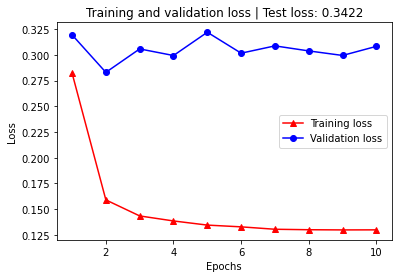

In [33]:
# plot training and validaiton loss over epochs
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "-r^" is for solid red line with triangle markers.
plt.plot(epochs, loss, '-r^', label='Training loss')
# "-b0" is for solid blue line with circle markers.
plt.plot(epochs, val_loss, '-bo', label='Validation loss')
plt.title('Training and validation loss | Test loss: {loss}'.format(loss=np.round(testResult[0], 4)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.savefig(results_path + '_loss_history')

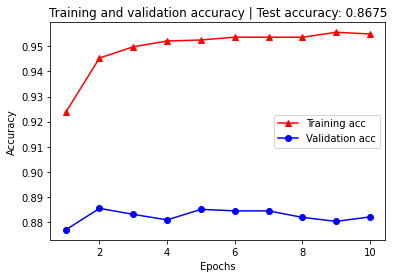

In [34]:
# plot training and validation accuracy over epochs
plt.clf()   # clear figure

plt.plot(epochs, acc, '-r^', label='Training acc')
plt.plot(epochs, val_acc, '-bo', label='Validation acc')
plt.title('Training and validation accuracy | Test accuracy: {accuracy}'.format(accuracy = np.round(testResult[1], 4)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

# plt.show()
plt.savefig(results_path + '_acc_history')

In [72]:
sampleLoader =  spektral.data.loaders.DisjointLoader(trainDataset[0:10], node_level=False, batch_size=10, epochs=1, shuffle=True)
x,a,e,i = [],[],[],[]
labels = []
for batch in sampleLoader:
    labels = batch[1]
    x,a,e,i = batch[0]
    print(batch)

((array([[-0.09127652, -0.10843979, -0.08000296, ..., -0.1268474 ,
        -0.0790683 , -0.08250892],
       [-0.11854362,  0.04742449, -0.02016414, ...,  0.07192121,
         0.04425791,  0.06978755],
       [-0.16536878,  0.02325122, -0.00168865, ...,  0.04442874,
        -0.0296917 ,  0.0110608 ],
       ...,
       [-0.17732394,  0.03671077,  0.10515954, ...,  0.0074924 ,
         0.00207563,  0.09237898],
       [ 0.04346668,  0.02642263,  0.0654704 , ...,  0.00481029,
         0.02680278,  0.06416886],
       [-0.00412835,  0.04959522,  0.06420626, ...,  0.02187742,
         0.03952674, -0.02741097]], dtype=float32), <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x577e3b0d0>, array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([0, 0, 0, ..., 9, 9, 9])), array([[0],
  

/Users/zeyuyang/miniforge3/envs/graphLearning/lib/python3.9/site-packages/spektral-1.1.0-py3.9.egg/spektral/data/utils.py:221: UserWarning: you are shuffling a 'TrainDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


In [215]:
print(stanzaTools.printSpareTensor(a)[0:500])

<SparseTensor shape=[2049, 2049] 
 values={
  [4, 0]: 1.0
  [4, 1]: 1.0
  [4, 2]: 1.0
  [4, 3]: 1.0
  [4, 12]: 1.0
  [4, 13]: 1.0
  [4, 26]: 1.0
  [4, 47]: 1.0
  [6, 5]: 1.0
  [6, 9]: 1.0
  [9, 7]: 1.0
  [9, 8]: 1.0
  [12, 6]: 1.0
  [12, 10]: 1.0
  [12, 11]: 1.0
  [12, 21]: 1.0
  [14, 16]: 1.0
  [16, 15]: 1.0
  [18, 19]: 1.0
  [21, 14]: 1.0
  [21, 17]: 1.0
  [21, 18]: 1.0
  [21, 20]: 1.0
  [26, 22]: 1.0
  [26, 23]: 1.0
  [26, 24]: 1.0
  [26, 25]: 1.0
  [26, 28]: 1.0
  [26, 41]: 1.0
  [28, 27]: 1


In [221]:
new_x = GCNConv(16)([x,a])
new_x2 = GCNConv(16)([new_x,a])

In [62]:
from spektral.datasets import QM9

In [63]:
dataset = QM9(amount=1000)  

44867584/44852087 [==============================] - 43s 1us/step
Loading QM9 dataset.
Reading SDF


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2878.29it/s]


In [ ]:
x[0]

Graph(n_nodes=107, n_node_features=128, n_edge_features=None, n_labels=1)